Row
    [0] Column(css_classes=['bordered-column'])
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] Markdown(str, min_height=100, sizing_mode='stretch_width')
        [2] PNG(str, sizing_mode='stretch_both')
        [3] Column(sizing_mode='stretch_height')
            [0] Markdown(str)
            [1] IntSlider(end=20, name='Max Factor MW slider', start=1, value=1)
    [1] Column
        [0] Row(css_classes=['bordered-row'])
            [0] ParamFunction(function, _pane=Column, defer_load=False)
        [1] Row(css_classes=['bordered-row'], min_height=320, min_width=150, sizing_mode='stretch_width')
            [0] HoloViews(Curve, height=300, sizing_mode='stretch_both', width=700)
            [1] HoloViews(Curve, height=300, sizing_mode='stretch_both', width=700)
        [2] Row(css_classes=['bordered-row'], min_height=320, min_width=150, sizing_mode='stretch_width')
            [0] HoloViews(Curve, height=300, sizing_mode='stretch_both', width=700)
            [1] HoloViews(Curve, height=300, sizing_mode='stretch_both', width=700)
        [3] Column(css_classes=['bordered-row'], sizing_mode='stretch_width')
            [0] Row
                [0] DataFrame(formatters={'Total Hashrate (PH/s)': ...}, sizing_mode='stretch_width', value=   MW  Total H...)
            [1] Row
                [0] FileDownload(button_type='primary', callback=<function get_csv a..., filename='simulazione_dynamic_data_..., label='📥 Export CSV')
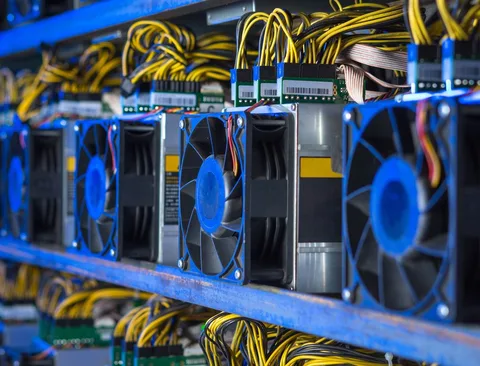

In [105]:
import pandas as pd
import numpy as np
import hvplot.pandas
import panel as pn
from bokeh.models import NumberFormatter
import io
pn.extension('tabulator')
pn.extension('vega')

def generate_data(max_mw):
    mw_values = np.arange(1, max_mw + 1)
    hashrate_totale = 1000 + 100 * np.sqrt(mw_values)
    coeff_ph_rate = 0.9 - 0.01 * np.log(mw_values)
    coeff_ph_rate = np.clip(coeff_ph_rate, 0.75, 0.90)  # limita tra 0.75 e 0.90
    produzione_btc = 0.0005 * np.sqrt(mw_values)
    efficienza_energetica = produzione_btc / mw_values
    data = {
        'MW': mw_values,
        'Total Hashrate (PH/s)': hashrate_totale,
        'Coefficient PH/rate': coeff_ph_rate,
        'Energy Consumed (MWh)': mw_values * 24,
        'BTC Production (BTC/day)': produzione_btc,
        'Cloud Blockchain Capacity': 100 * mw_values,
        'Transaction Validation Fee': 0.0001 * mw_values ** 1.1,
        'Other Services (unit)': 5 + mw_values,
        'Energy Efficiency (BTC/MW)': efficienza_energetica,
        'Latency Transaction (s)': np.clip(10 - 0.2 * mw_values, 1, None),
        'Active Nodes': 100 + 10 * mw_values,
        'ASIC Usage (%)': 30 + 3 * mw_values,
    }
    df = pd.DataFrame(data)
    return df

slider_mw = pn.widgets.IntSlider(name='Max Factor MW slider', start=1, end=20, step=1, value=1)
# Usa Tabulator per la tabella con altezza e scrolling nativo
tbDataFrame = pn.widgets.Tabulator(pd.DataFrame()
                                    #max_height=0,
                                    #selectable=1, 
                                    #layout='fit_columns', 
                                    #show_index=False,
                                    #pagination='local', page_size=30
                                )

plot1 = pn.pane.HoloViews(sizing_mode='stretch_both')
plot2 = pn.pane.HoloViews(sizing_mode='stretch_both')
plot3 = pn.pane.HoloViews(sizing_mode='stretch_both')
plot4 = pn.pane.HoloViews(sizing_mode='stretch_both')

def update_card_metrics(mw):
    max_mw = mw ** 2
    global df 
    df = generate_data(max_mw)
    
    # format number values 
    def format_millions_thousands(value):
        if value >= 1_000_000:
            return f"{value / 1_000_000:.0f}M"
        elif value >= 1_000:
            return f"{value / 1_000:.0f}K"
        else:
            return str(value)
    
    # Selected last row and memorize the metrics
    selected_row = df.loc[df['MW'] == df['MW'].max()]
    cloud_blockchain = selected_row['Cloud Blockchain Capacity'].values[0]
    transaction_fee = selected_row['Transaction Validation Fee'].values[0]
    active_nodes = selected_row['Active Nodes'].values[0]
    
    # Style metrics cards
    card_style = {
        'background': 'linear-gradient(to right, #05ed43, #aaf2bd)',
        'padding': '15px',
        'margin': '10px',
        'border-radius': '8px',
        'box-shadow': '2px 2px 6px #ccc',
        'flex': '1',
        'min-width': '200px',
        'text-align': 'center',
        'font-size': '16px'
    }
    
    # Layout metrix 
    # global cards_metrics
    return pn.Column(
        pn.Row(
            pn.pane.Markdown(f"### Cloud Blockchain Capacity\n**{cloud_blockchain:,.0f}**", styles=card_style),
            pn.pane.Markdown(f"### Transaction Validation Fee\n**{transaction_fee:,.4f}**", styles=card_style),
            pn.pane.Markdown(f"### Active Nodes\n**{active_nodes}**", styles=card_style),
            margin=10,
            sizing_mode="stretch_width"
        )
    )      

def update_data(event=None):
    max_mw = slider_mw.value ** 2
    global df 
    df = generate_data(max_mw)
    
    # Update table with the new dataframe
    tbDataFrame.value = df

    # Automatically select the last row in the table data frame
    last_index = len(df) - 1
    tbDataFrame.selected = [last_index]
    
    # Update plots
    plot1.object = df.hvplot.line(
        x='MW', y='BTC Production (BTC/day)', title='Produzione BTC vs MW (sqrt trend)',
        height=300, line_width=2, color='blue'
    )
    plot2.object = df.hvplot.line(
        x='MW', y='Cloud Blockchain Capacity', title='Cloud Blockchain vs MW',
        height=300, line_width=2, color='green'
    )
    plot3.object = df.hvplot.line(
        x='MW', y='Transaction Validation Fee', title='Fee Convalida Transazioni vs MW',
        height=300, line_width=2, color='red'
    )
    plot4.object = df.hvplot.line(
        x='MW', y='Energy Efficiency (BTC/MW)', title='Efficienza Energetica vs MW',
        height=300, line_width=2, color='purple'
    )

def get_csv():
    if df is not None and not df.empty:
        csv_bytes = df.to_csv(index=False).encode()
        return io.BytesIO(csv_bytes)
        #return io.BytesIO(df.to_csv(index=False).encode())


filedl = pn.widgets.FileDownload(
    callback=get_csv,
    filename='simulazione_dynamic_data_driven_export.csv',
    button_type='primary',
    label="📥 Export CSV"  # questa etichetta sarà visualizzata sul pulsante
)

# Responsive layout with binding
slider_mw.param.watch(update_data, 'value')
cards_metrics = pn.bind(update_card_metrics, mw=slider_mw)
 
# CSS style to add a border to each line
row_style = """
    .bordered-row {
        border: 0.5px solid #ddd; /* Bordo grigio chiaro */
        padding: 5px; /* Spazio interno */
        margin-bottom: 7px; /* Spazio sotto ogni riga */
        border-radius: 4px; /* Bordi arrotondati */
        background-color: #f9f9f9; /* Colore di sfondo leggero */
    }
"""
# CSS style to add a border to each column
column_style = """
.bordered-column {
    border: 0.5px solid #ddd;
    border-radius: 4px;
    background-color: #f9f9f9;
    max-width: 320px;
    margin-right: 10px;
}
"""
# Load CSS style
pn.extension(raw_css=[row_style]) 
pn.extension(raw_css=[column_style]) 

update_data()

# Final responsive layout
# Create responsive function
row_0 = pn.Row(cards_metrics, css_classes=['bordered-row'])
row_1 = pn.Row(plot1, plot2, sizing_mode='stretch_width', min_width=150, min_height=320, css_classes=['bordered-row'])
row_2 = pn.Row(plot3, plot4, sizing_mode='stretch_width', min_width=150, min_height=320, css_classes=['bordered-row'])

# Create the NumberFormatter for two decimal places
two_decimals_formatter = NumberFormatter(format="0,0.00")

# Create the DataFrame widget specifying the formatters correctly
table_widget = pn.widgets.DataFrame(
    tbDataFrame,
    sizing_mode='stretch_width',
    formatters={'Total Hashrate (PH/s)': two_decimals_formatter}
)
#Format dimension 'Total Hashrate (PH/s)' before displaying the dataframe
row_table = pn.Column(pn.Row(table_widget),
                      pn.Row(filedl),
                      sizing_mode='stretch_width', 
                      css_classes=['bordered-row']
            )
column_data = pn.Column(row_0, row_1, row_2, row_table)
sidebar = pn.Column(pn.pane.Markdown("# **Dynamic Bitcoin Mining Simulation Model**", sizing_mode="stretch_width"),
              pn.pane.Markdown("#### **This project simulates Bitcoin mining metrics based on varying power consumption (MW). It produces realistic outputs reflecting mining performance, efficiency, network parameters, and economics, all driven by industry benchmarks around 2025.**", sizing_mode="stretch_width", min_height=100),
              pn.pane.PNG('image.png', sizing_mode = 'stretch_both'),
              #pn.pane.Markdown("## Settings"),
              pn.Column(
                        pn.pane.Markdown("## Settings"),
                        slider_mw,
                        sizing_mode="stretch_height",
              ),
              css_classes=['bordered-column']                    
                     
)

# Final interface
layout = pn.Row(
    sidebar,
    column_data, 
)
layout.servable()


In [73]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
